In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import scipy as sc
import numpy as np
import glob
from tqdm.auto import tqdm

In [2]:
test_imgs = glob.glob('cnnimagecodec/test/*.png')
train_imgs = glob.glob('cnnimagecodec/train/*.png')

In [3]:
class ImageCodec:
    def __init__(self):
        self.pca = None
        self.n = None
        self.m = None
        self.img_size = None #(N, M, K)
        
    def set_shape(self, image):
        if self.img_size is None: 
            self.img_size = image.shape
        assert(image.shape == self.img_size)
        
    def split_transform(self, image):
        N, M, K = self.img_size
        X = image.transpose((1,2,0)).reshape((M, K, N // self.n, self.n)) \
                     .transpose((1,2,3,0)).reshape((K, N // self.n, self.n, M // self.m, self.m)) \
                     .transpose((1,3,2,4,0)).reshape((N * M // (self.n * self.m), self.n * self.m * K))
        return X
    
    
    def train(self, train_imgs, n_components = 16, n = 8, m = 8):
        self.n = n
        self.m = m
        train_data = []
        for f in tqdm(train_imgs):
            image = plt.imread(f)
            self.set_shape(image)
            train_data.append(self.split_transform(image))
        train_data = np.concatenate(train_data)
        print(train_data.shape)
        self.pca = PCA(n_components=n_components)
        self.pca.fit(train_data)
        
    def encode_decode(self, image, draw_picture=True):
        self.set_shape(image)
        figsize = (3,3)
        if draw_picture:
            plt.figure(figsize=figsize)
            plt.imshow(image)
            plt.axis('off')
            plt.show()
        X = self.split_transform(image)
        
        Y = self.pca.transform(X) # encode
        print(f'Compressed vectors shape: {Y.shape}')
        X_hat = self.pca.inverse_transform(Y) # decode

        max_value = X.max()
        X_hat = X_hat * (X_hat <= max_value) + max_value * (X_hat > max_value)
        X_hat = X_hat * (X_hat >= 0) / max_value
        
        N, M, K = self.img_size
        X_hat = X_hat.reshape((N // self.n, M // self.m, self.n, self.m, K)).transpose((1,3,4,0,2)) \
                     .reshape((M // self.m, self.m, K, N)).transpose((3,2,0,1)) \
                     .reshape((N, K, M)).transpose((0,2,1)) \

        plt.figure(figsize=figsize)
        plt.imshow(X_hat)
        plt.axis('off')
        #plt.title(f'Compressed with {n_components} components')
        plt.show()
        return dict(enc=Y, dec=X_hat)

In [4]:
codec = ImageCodec()

In [5]:
codec.train(train_imgs, n_components = 16, n = 8, m = 8)

  0%|          | 0/204 [00:00<?, ?it/s]

(52224, 192)


  0%|          | 0/5 [00:00<?, ?it/s]

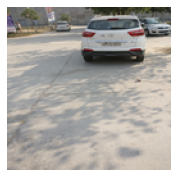

Compressed vectors shape: (256, 16)


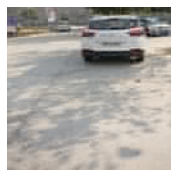

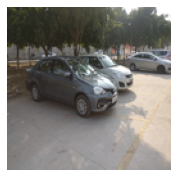

Compressed vectors shape: (256, 16)


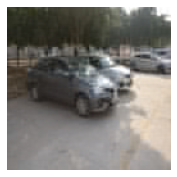

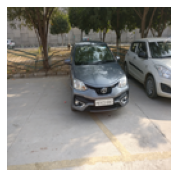

Compressed vectors shape: (256, 16)


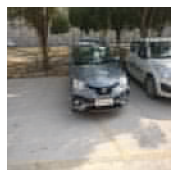

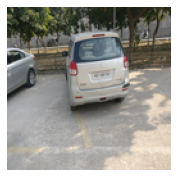

Compressed vectors shape: (256, 16)


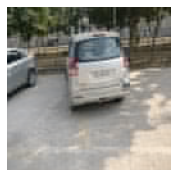

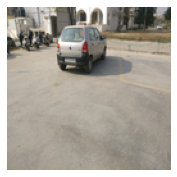

Compressed vectors shape: (256, 16)


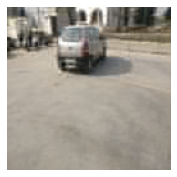

In [6]:
for f in tqdm(test_imgs[:5]):
    image = plt.imread(f)
    codec.encode_decode(image)

In [11]:
128*128*3, 256*16

(49152, 4096)

In [ ]:
#(128, 128, 3) -> (128, 3, 128) -> (128, 3, 16, 8)
#(3, 16, 8, 128) -> (3, 16, 8, 16, 8)
#(16, 16, 8, 8, 3) -> (256, 192)

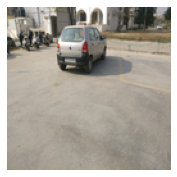

Compressed vectors shape: (256, 16)


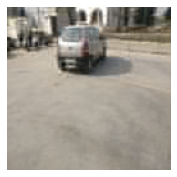

In [7]:
res = codec.encode_decode(image)

In [9]:
res['enc']

array([[-1.9092382e+00,  3.2506278e-03, -5.4060596e-01, ...,
         4.0967617e-02, -1.0132058e-02, -2.3446141e-02],
       [-1.1084253e+00, -1.2119758e+00,  1.2025619e+00, ...,
        -1.4618075e-01, -1.8751448e-01, -7.6177083e-02],
       [ 3.5596561e+00, -5.6646913e-01,  4.0966386e-01, ...,
         1.0659667e-01, -1.4253432e-01, -4.0845063e-02],
       ...,
       [ 1.1880211e+00, -2.2438566e-01,  6.9051914e-02, ...,
        -2.2678446e-02, -1.5031913e-02, -7.4843350e-03],
       [ 1.2937881e+00, -1.8558753e-01, -4.5792647e-02, ...,
         6.5456848e-03, -2.9296391e-02, -5.2126832e-03],
       [ 9.1574401e-01, -5.6383088e-02, -1.4208251e-01, ...,
        -3.4353599e-02,  6.9195509e-02, -1.1645276e-02]], dtype=float32)